<a href="https://colab.research.google.com/github/aya-soltani/MLProject/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python tensorflow


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import pandas as pd

#  Chemin vers ton dossier d’images dans Google Drive
data_path = '/content/drive/MyDrive/Datta'
files = os.listdir(data_path)

#  Listes pour stocker les infos
image_paths = []
ages = []
genders = []

# Lecture des fichiers et extraction de l'âge et du genre
for file in files:
    if file.endswith(".jpg"):
        try:
            parts = file.split('_')
            age = int(parts[0])
            gender = int(parts[1])

            image_paths.append(os.path.join(data_path, file))
            ages.append(age)
            genders.append(gender)
        except:
            continue

#  Création du DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'age': ages,
    'gender': genders
})

#  Ajout du label final (0=Homme, 1=Femme, 2=Enfant)
def assign_label(row):
    if row['age'] <= 12:
        return 2
    elif row['gender'] == 0:
        return 0
    else:
        return 1

df['label'] = df.apply(assign_label, axis=1)

# Aperçu des premières lignes
df.head()


,image_path,age,gender,label
0,/content/drive/MyDrive/Datta/86_1_0_2017011018...,86,1,1
1,/content/drive/MyDrive/Datta/9_0_0_20170110220...,9,0,2
2,/content/drive/MyDrive/Datta/8_1_0_20170109202...,8,1,2
3,/content/drive/MyDrive/Datta/90_1_0_2017011018...,90,1,1
4,/content/drive/MyDrive/Datta/90_0_0_2017011121...,90,0,0


In [22]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('GPU device name:', device_name)

GPU device name: /device:GPU:0


Création des matrices X et y

In [23]:
import cv2
import numpy as np

IMG_SIZE = 100
X = []
y = []

for i, row in df.iterrows():
    try:
        img = cv2.imread(row['image_path'])
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Normalisation
        X.append(img)
        y.append(row['label'])
    except:
        continue

X = np.array(X)
y = np.array(y)

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")


X shape : (10047, 100, 100, 3)
y shape : (10047,)


In [24]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Encodage one-hot des labels (obligatoire pour softmax)
y_cat = to_categorical(y, num_classes=3)

# Split des données (80% entraînement / 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Vérification des dimensions
print(f"X_train : {X_train.shape}")
print(f"y_train : {y_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"y_test  : {y_test.shape}")


X_train : (8037, 100, 100, 3)
y_train : (8037, 3)
X_test  : (2010, 100, 100, 3)
y_test  : (2010, 3)


Création et entraînement du modèle CNN

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Entrée
input_layer = Input(shape=(100, 100, 3))

# Bloc 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Bloc 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Bloc 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Bloc 4 (profond)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Fully connected
x = Flatten()(x)
x = Dense(256, activation='relu', name='feature_layer')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Sortie
output_layer = Dense(3, activation='softmax')(x)

# Création du modèle
model = Model(inputs=input_layer, outputs=output_layer)

# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1)


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5126 - loss: 2.1036 - val_accuracy: 0.5199 - val_loss: 0.9468
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7228 - loss: 0.7055 - val_accuracy: 0.7289 - val_loss: 0.6870
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7673 - loss: 0.5866 - val_accuracy: 0.8396 - val_loss: 0.4545
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8183 - loss: 0.4965 - val_accuracy: 0.7587 - val_loss: 0.5747
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8386 - loss: 0.4190 - val_accuracy: 0.8346 - val_loss: 0.4275
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8515 - loss: 0.3939 - val_accuracy: 0.8806 - val_loss: 0.3539
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8804 - loss: 0.3264 - val_accuracy: 0.8806 - val_loss: 0.3551
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8655 - loss: 0.3581 - val_acc

 afficher les résultats d'entraînement

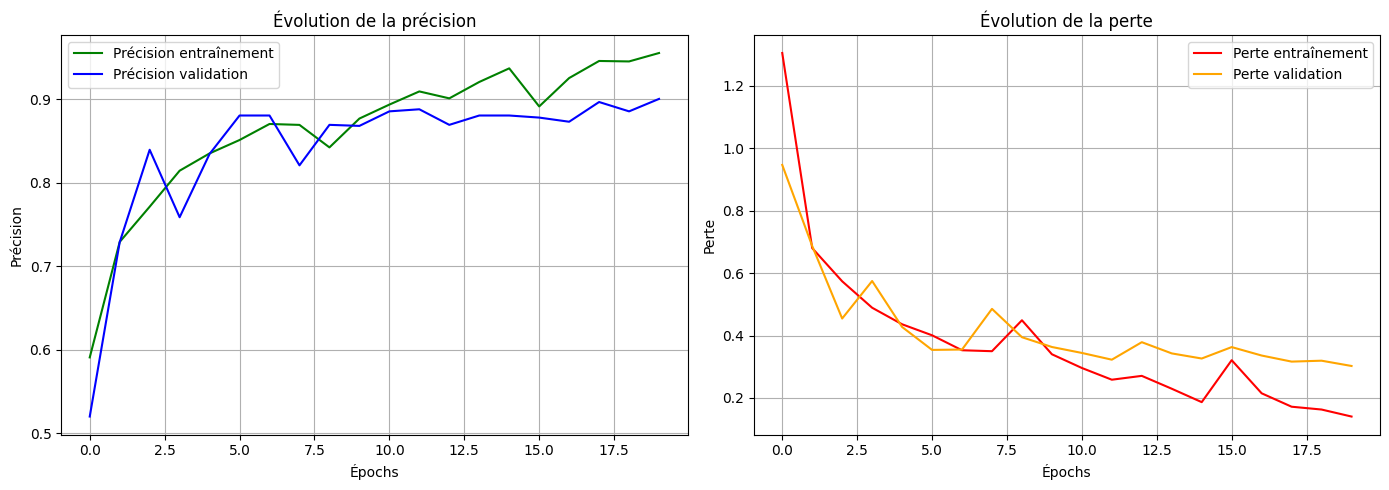

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # 📈 Précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision entraînement', color='green')
    plt.plot(epochs_range, val_acc, label='Précision validation', color='blue')
    plt.title('Évolution de la précision')
    plt.xlabel('Épochs')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)

    # 📉 Perte (loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte entraînement', color='red')
    plt.plot(epochs_range, val_loss, label='Perte validation', color='orange')
    plt.title('Évolution de la perte')
    plt.xlabel('Épochs')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#  Affichage
plot_training_history(history)


Évaluer ton CNN sur les données de test

In [27]:
# Évaluation du modèle CNN sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)

print(f"✅ Précision sur les données de test : {accuracy:.2%}")
print(f"📉 Perte (loss) sur les données de test : {loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8965 - loss: 0.2969
✅ Précision sur les données de test : 90.85%
📉 Perte (loss) sur les données de test : 0.2649


Afficher le rapport de classification détaillé

In [28]:
from sklearn.metrics import classification_report
import numpy as np

# Prédictions
y_pred_cnn = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_cnn, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Rapport
print(classification_report(y_true_labels, y_pred_labels, target_names=['Homme', 'Femme', 'Enfant']))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

       Homme       0.90      0.89      0.89       559
       Femme       0.90      0.90      0.90       727
      Enfant       0.93      0.93      0.93       724

    accuracy                           0.91      2010
   macro avg       0.91      0.91      0.91      2010
weighted avg       0.91      0.91      0.91      2010



**Modèle Random Forest**

Aplatir les images pour le Random Forest

In [29]:
# On transforme les images en vecteurs (flatten)
X_flat = X.reshape(X.shape[0], -1)

print("Nouvelles dimensions de X :", X_flat.shape)  # ex: (1000, 30000)



Nouvelles dimensions de X : (10047, 30000)


Diviser les données en train / test

In [30]:
from sklearn.model_selection import train_test_split

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_flat, y, test_size=0.2, random_state=42)


Entraîner le Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Création et entraînement
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Prédictions
y_pred_rf = rf_model.predict(X_test_rf)

# Évaluation
print(classification_report(y_test_rf, y_pred_rf, target_names=["Homme", "Femme", "Enfant"]))

              precision    recall  f1-score   support

       Homme       0.79      0.79      0.79       559
       Femme       0.74      0.84      0.78       727
      Enfant       0.92      0.79      0.85       724

    accuracy                           0.81      2010
   macro avg       0.82      0.81      0.81      2010
weighted avg       0.82      0.81      0.81      2010



Evaluer les performances

In [32]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = rf_model.predict(X_test_rf)

acc_rf = accuracy_score(y_test_rf, y_pred_rf)
print(f"✅ Précision de Random Forest : {acc_rf:.2%}")

print("\n📄 Rapport de classification :")
print(classification_report(y_test_rf, y_pred_rf, target_names=["Homme", "Femme", "Enfant"]))


✅ Précision de Random Forest : 80.85%

📄 Rapport de classification :
              precision    recall  f1-score   support

       Homme       0.79      0.79      0.79       559
       Femme       0.74      0.84      0.78       727
      Enfant       0.92      0.79      0.85       724

    accuracy                           0.81      2010
   macro avg       0.82      0.81      0.81      2010
weighted avg       0.82      0.81      0.81      2010



Matrice de confusion

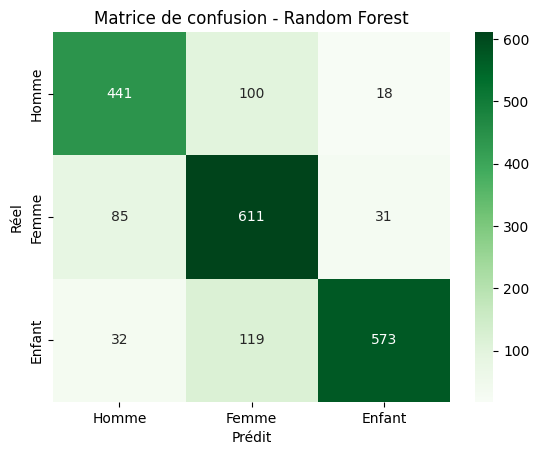

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_rf, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Homme", "Femme", "Enfant"], yticklabels=["Homme", "Femme", "Enfant"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Random Forest")
plt.show()

Modele DCNR

Extraire les features depuis le CNN

In [34]:
from tensorflow.keras.models import Model

# On crée un modèle qui sort la couche 'feature_layer'

feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)

# Extraction des features
X_train_feat = feature_extractor.predict(X_train)
X_test_feat = feature_extractor.predict(X_test)

print("Shape des features extraits :", X_train_feat.shape)




252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Shape des features extraits : (8037, 256)


Entraîner un Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1. Transformer les labels one-hot en entiers
y_train_rf = np.argmax(y_train, axis=1)
y_test_rf = np.argmax(y_test, axis=1)

# 2. Créer et entraîner le modèle Random Forest
rf_dcnr = RandomForestClassifier(n_estimators=300, max_depth=40, random_state=42)  # ← optimisé
rf_dcnr.fit(X_train_feat, y_train_rf)

# 3. Prédictions
y_pred_dcnr = rf_dcnr.predict(X_test_feat)

# 4. Précision
acc_dcnr = accuracy_score(y_test_rf, y_pred_dcnr)
print(f"✅ Précision du modèle DCNR : {acc_dcnr:.2%}")

# 5. Rapport détaillé
print("\n📄 Rapport de classification :")
print(classification_report(y_test_rf, y_pred_dcnr, target_names=["Homme", "Femme", "Enfant"]))


✅ Précision du modèle DCNR : 91.00%

📄 Rapport de classification :
              precision    recall  f1-score   support

       Homme       0.88      0.91      0.89       559
       Femme       0.90      0.91      0.90       727
      Enfant       0.95      0.91      0.93       724

    accuracy                           0.91      2010
   macro avg       0.91      0.91      0.91      2010
weighted avg       0.91      0.91      0.91      2010



In [36]:
rf_dcnr = RandomForestClassifier(
    n_estimators=300,         # 🌳 1. Nombre d'arbres
    max_depth=40,             # 📏 2. Profondeur maximale des arbres
    class_weight='balanced', # ⚖️ 3. Pondération des classes
    random_state=42          # 🎲 4. Reproductibilité
)


Afficher la matrice de confusion

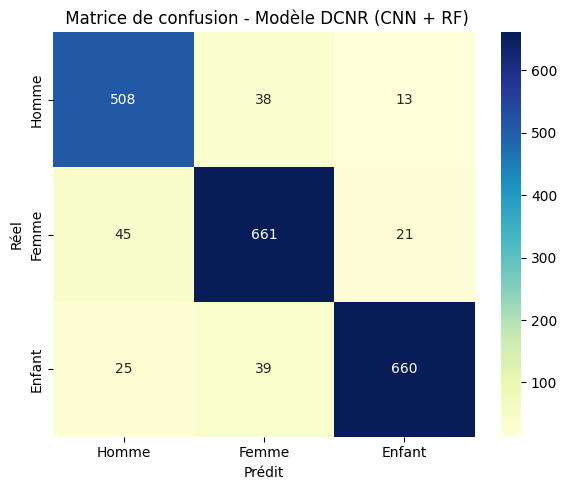

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
cm = confusion_matrix(y_test_rf, y_pred_dcnr)

# Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Homme', 'Femme', 'Enfant'],
            yticklabels=['Homme', 'Femme', 'Enfant'])
plt.title(" Matrice de confusion - Modèle DCNR (CNN + RF)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


Récupérer les précisions de chaque modèle

In [38]:
from sklearn.metrics import accuracy_score

# Précision du CNN (softmax)
acc_cnn = history.history['val_accuracy'][-1]  # dernière précision de validation

# Précision du Random Forest seul
acc_rf = accuracy_score(y_test_rf, y_pred_rf)

# Précision du DCNR (Random Forest sur features CNN)
acc_dcnr = accuracy_score(y_test_rf, y_pred_dcnr)


Créer un tableau comparatif

In [39]:
import pandas as pd

results_df = pd.DataFrame({
    'Modèle': ['Random Forest', 'CNN (softmax)', 'DCNR (CNN + RF)'],
    'Précision (%)': [acc_rf * 100, acc_cnn * 100, acc_dcnr * 100]
})

results_df


,Modèle,Précision (%)
0,Random Forest,80.845771
1,CNN (softmax),90.049750
2,DCNR (CNN + RF),90.995025


Créer un graphique en barres

In [41]:
best_model = results_df.loc[results_df['Précision (%)'].idxmax()]['Modèle']
best_score = results_df['Précision (%)'].max()

print(f"📝 Conclusion : Le modèle le plus performant est **{best_model}** avec une précision de {best_score:.2f}%.")


📝 Conclusion : Le modèle le plus performant est **DCNR (CNN + RF)** avec une précision de 91.00%.
